<a href="https://colab.research.google.com/github/hamdansethi/NLP/blob/main/08__Sentiment_Analysis_with_a_Data_Driven_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

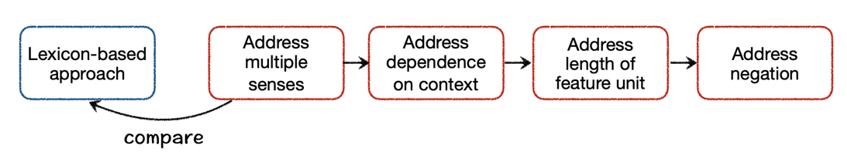

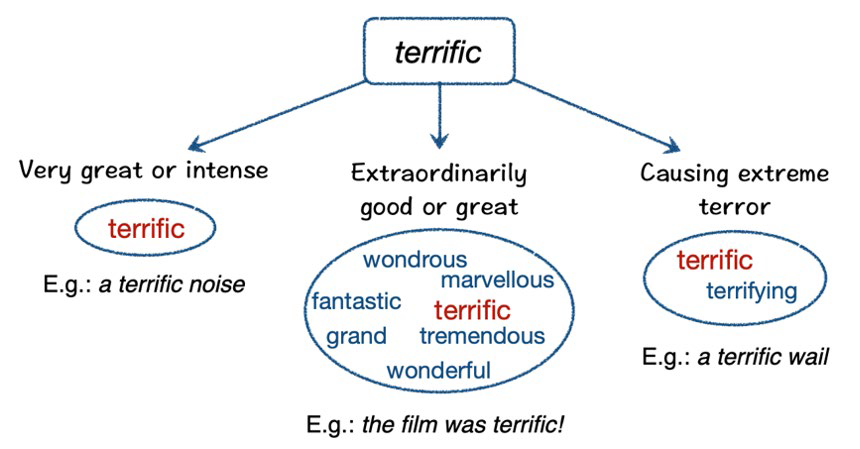

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

print(list(swn.senti_synsets('joy')))
print(list(swn.senti_synsets('trouble')))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


[SentiSynset('joy.n.01'), SentiSynset('joy.n.02'), SentiSynset('rejoice.v.01'), SentiSynset('gladden.v.01')]
[SentiSynset('trouble.n.01'), SentiSynset('fuss.n.02'), SentiSynset('trouble.n.03'), SentiSynset('trouble.n.04'), SentiSynset('worry.n.02'), SentiSynset('trouble.n.06'), SentiSynset('disturb.v.01'), SentiSynset('trouble.v.02'), SentiSynset('perturb.v.01'), SentiSynset('trouble_oneself.v.01'), SentiSynset('trouble.v.05')]


In [2]:
joy1 = swn.senti_synset('joy.n.01')
joy2 = swn.senti_synset('joy.n.02')

trouble1 = swn.senti_synset('trouble.n.03')
trouble2 = swn.senti_synset('trouble.n.04') #A

categories = ["Joy1", "Joy2", "Trouble1", "Trouble2"]
rows = []
rows.append(["List", "Positive score", "Negative Score"]) #B
accs = {}

accs["Joy1"] = [joy1.pos_score(), joy1.neg_score()]
accs["Joy2"] = [joy2.pos_score(), joy2.neg_score()]
accs["Trouble1"] = [trouble1.pos_score(), trouble1.neg_score()]
accs["Trouble2"] = [trouble2.pos_score(), trouble2.neg_score()] #C
for cat in categories:
  rows.append([cat, f"{accs.get(cat)[0]:.3f}",
                    f"{accs.get(cat)[1]:.3f}"])

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
  print(''.join(' {:{width}} '.format(row[i], width=column_widths[i])
                for i in range(0, len(row)))) #D

#A Access specific synsets (senses) for each of the input words
#B Use the printout routine from the previous chapters to print the results as a table
#C Each synset has a positive pos_score() and a negative neg_score()assigned to it
#D Print positive and negative scores for each synset

 List      Positive score  Negative Score 
 Joy1      0.500           0.250          
 Joy2      0.375           0.000          
 Trouble1  0.000           0.625          
 Trouble2  0.000           0.500          


In [3]:
synsets = swn.senti_synsets('terrific', 'a') #A

for synset in synsets:
  print("pos: +" + str(synset.pos_score()) + " neg: -" + str(synset.neg_score())) #B

#A Access synsets for a given word of a specific part of speech using an additional argument in senti_synsets
#B Print out positive and negative scores for each synset

pos: +0.25 neg: -0.25
pos: +0.75 neg: -0.0
pos: +0.0 neg: -0.625


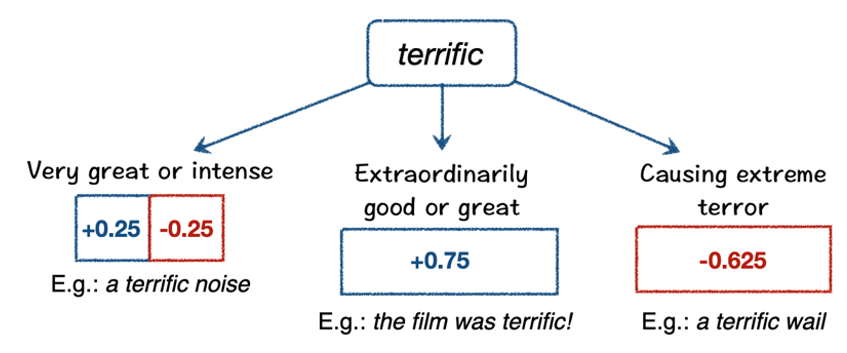

In [4]:
from nltk.corpus import wordnet as wn #A

def convert_tags(pos_tag):
    if pos_tag.startswith("JJ"):
         return wn.ADJ
    elif pos_tag.startswith("NN"):
         return wn.NOUN
    elif pos_tag.startswith("RB"):
         return wn.ADV
    elif pos_tag.startswith("VB") or pos_tag.startswith("MD"):
         return wn.VERB
    return None #B

def swn_decisions(a_dict, label):
    decisions = []
    for rev_id in a_dict.keys():
        score = 0
        neg_count = 0
        pos_count = 0
        for token in a_dict.get(rev_id):
            wn_tag = convert_tags(token.tag_)
            if wn_tag in (wn.ADJ, wn.ADV,
                          wn.NOUN, wn.VERB): #C
                synsets = list(swn.senti_synsets( #D
                    token.lemma_, pos=wn_tag))
                if len(synsets)>0:
                    temp_score = 0.0
                    for synset in synsets:
                        temp_score += synset.pos_score() - synset.neg_score() #E

                    score += temp_score/len(synsets)
        if score < 0:
            decisions.append((-1, label))
        else:
            decisions.append((1, label))
    return decisions #F


#A Import WordNet interface from NLTK for part-of-speech tag conversion
#B Function convert_tags translates between the tags used in the two toolkits
#C For each word token in the review, check its part-of-speech tag
#D Retrieve the SentiWordNet synsets based on the lemma of the word and its part-of-speech tag
#E Aggregate the score as the balance between the positive and negative scores of the word synsets
#F As before, return the list of decisions, where each item maps the predicted score to the actual one

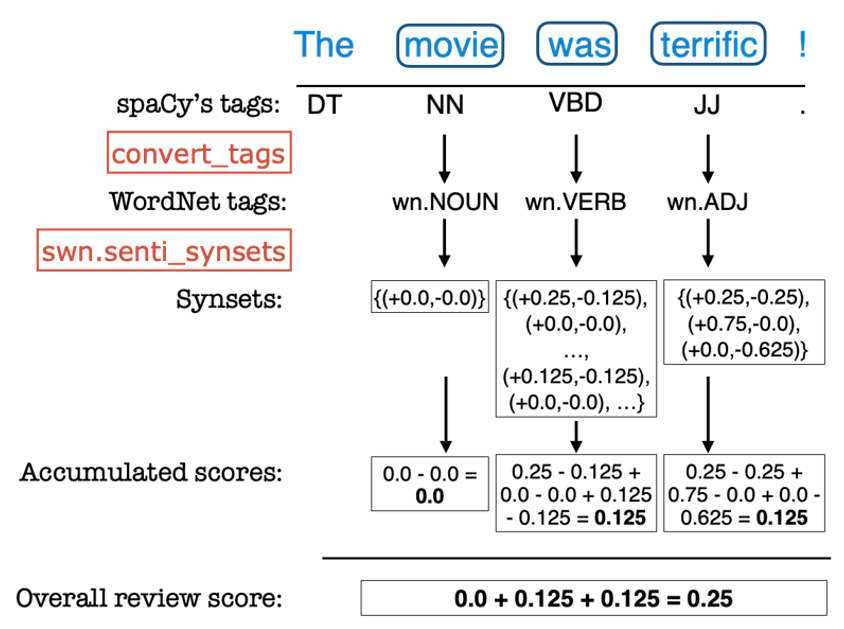

In [6]:
import tarfile

file_name = "review_polarity.tar.gz"

with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall("extracted_data")
    print("Extraction complete!")

Extraction complete!


In [7]:
import os, codecs

def read_in(folder):

  files = os.listdir(folder)
  a_dict = {}

  for a_file in sorted(files):
    if not a_file.startswith("."):
      with codecs.open(folder + a_file, encoding='ISO-8859-1', errors ='ignore') as f:
        file_id = a_file.split(".")[0].strip()
        a_dict[file_id] = f.read()
      f.close()
  return a_dict

In [8]:
folder = "/content/extracted_data/txt_sentoken/"
pos_dict = read_in(folder + "pos/")
neg_dict = read_in(folder + "neg/")

In [9]:
def tokenize(text):
  text.replace("\n", " ")
  return text.split()

def statistics(a_dict):
  length = 0
  sent_length = 0
  num_sents = 0
  vocab = []

  for review in a_dict.values():
    length += len(tokenize(review))
    sents = review.split("\n")
    num_sents += len(sents)
    for sent in sents:
      sent_length += len(tokenize(sent))
    vocab += tokenize(review)

  avg_length = float(length)/len(a_dict)
  avg_sent_length = float(sent_length)/num_sents
  vocab_size = len(set(vocab))
  diversity = float(length)/float(vocab_size)

  return avg_length, avg_sent_length, vocab_size, diversity

categories = ["Positive", "Negative"]
rows = []
rows.append(["Category", "Avg_Len(Review)", "Avg_Len(Sent)", "Vocabulary Size", "Diversity"])

stats = {}
stats["Positive"] = statistics(pos_dict)
stats["Negative"] = statistics(neg_dict)

for cat in categories:
  rows.append([cat, f"{stats.get(cat)[0]:.6f}",
                    f"{stats.get(cat)[1]:.6f}",
                    f"{stats.get(cat)[2]:.6f}",
                    f"{stats.get(cat)[3]:.6f}"])

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]

for row in rows:
  print(''.join(' {:{width}} '.format(row[i], width=column_widths[i]) for i in range(0, len(row))))

 Category  Avg_Len(Review)  Avg_Len(Sent)  Vocabulary Size  Diversity 
 Positive  787.051000       23.191531      36805.000000     21.384350 
 Negative  705.630000       21.524266      34542.000000     20.428174 


In [10]:
def vocab_difference(list1, list2):
    vocab1 = []
    vocab2 = []
    for rev in list1:
        vocab1 += tokenize(rev)
    for rev in list2:
        vocab2 += tokenize(rev)

    return sorted(list(set(vocab1) - set(vocab2)))

pos_wordlist = pos_dict.values()
neg_wordlist = neg_dict.values()

In [11]:
import spacy
nlp = spacy.load("en_core_web_sm")

def spacy_preprocess_reviews(source):
    source_docs = {}

    index = 0
    for review_id in source.keys():
        source_docs[review_id] = nlp(
            source.get(review_id).replace("\n", ""),
            disable=["ner"])
        if index>0 and (index%200)==0:
            print(str(index) + " reviews processed")
        index += 1
    print("Dataset processed")
    return source_docs

pos_docs = spacy_preprocess_reviews(pos_dict)
neg_docs = spacy_preprocess_reviews(neg_dict)

200 reviews processed
400 reviews processed
600 reviews processed
800 reviews processed
Dataset processed
200 reviews processed
400 reviews processed
600 reviews processed
800 reviews processed
Dataset processed


In [12]:
def get_swn_accuracy(pos_docs, neg_docs):
    decisions_pos = swn_decisions(pos_docs, 1)
    decisions_neg = swn_decisions(neg_docs, -1) #A
    decisions_all = decisions_pos + decisions_neg
    lists = [decisions_pos, decisions_neg, decisions_all]
    accuracies = []
    for i in range(0, len(lists)):
        match = 0
        for item in lists[i]:
            if item[0]==item[1]: #B
                match += 1
        accuracies.append(float(match)/
                          float(len(lists[i]))) #C
    return accuracies


accuracies = get_swn_accuracy(pos_docs, neg_docs)

rows = []
rows.append(["List", "Acc(positive)", "Acc(negative)", "Acc(all)"])
rows.append(["SentiWordNet", f"{accuracies[0]:.6f}",
                f"{accuracies[1]:.6f}",
                f"{accuracies[2]:.6f}"])

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
    print(''.join(' {:{width}} '.format(row[i], width=column_widths[i])
                  for i in range(0, len(row)))) #D

#A Save the label predictions for the pos_docs and neg_docs
#B When the predicted score equals the actual score, consider it a match
#C Accuracy reflects the proportion of cases where the predicted score matches the actual one
#D As before, print out the results as a table using printing routine

 List          Acc(positive)  Acc(negative)  Acc(all) 
 SentiWordNet  0.684000       0.685000       0.684500 


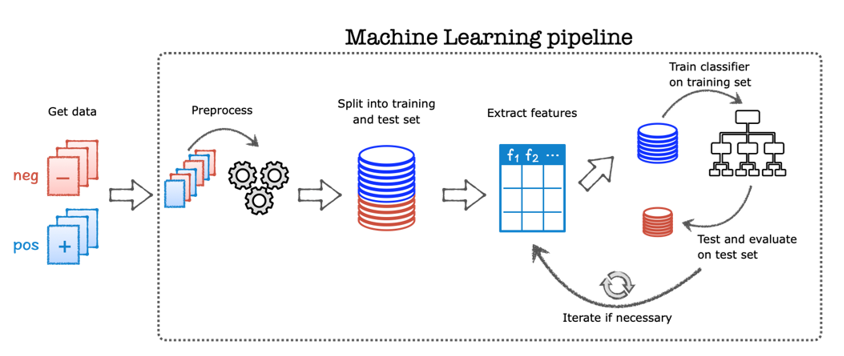

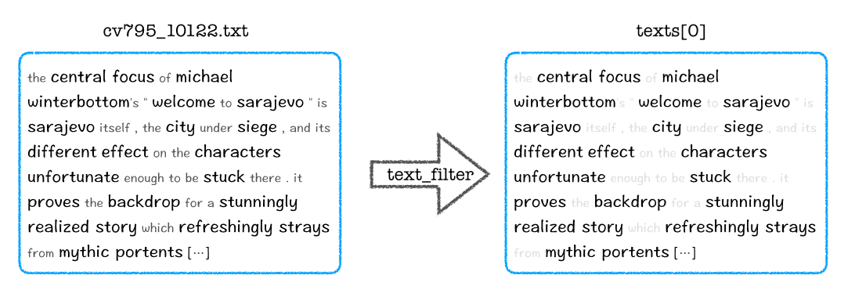

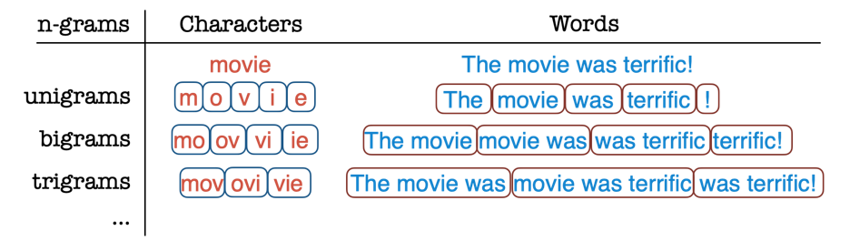

In [13]:
import random #A
import string
from spacy.lang.en.stop_words import STOP_WORDS as stopwords_list
punctuation_list = [punct for punct in string.punctuation] #B

def text_filter(a_dict, label, exclude_lists): #C
    data = []
    for rev_id in a_dict.keys():
        tokens = []
        for token in a_dict.get(rev_id):
            if not token.text in exclude_lists:
                tokens.append(token.text) #D
        data.append((' '.join(tokens), label))
    return data #E

def prepare_data(pos_docs, neg_docs, exclude_lists):
    data = text_filter(pos_docs, 1, exclude_lists)
    data += text_filter(neg_docs, -1, exclude_lists) #F
    random.seed(42)
    random.shuffle(data) #G
    texts = []
    labels = []
    for item in data:
        texts.append(item[0])
        labels.append(item[1])
    return texts, labels #H

texts, labels = prepare_data(pos_docs, neg_docs, punctuation_list) #I

print(len(texts), len(labels))
print(texts[0]) #J

#A Add some useful imports
#B string.punctuation is a string of punctuation marks, so let’s convert it to a list for convenience
#C Pass in a_dict, a label, and exclude_lists as arguments
#D For the word forms that are not in the exclude_lists, add the word forms to the output
#E Return data, with the first element being a filtered down version of a review and the second – its label
#F Apply the text_filter function to both types of reviews and store the results in one data structure
#G Shuffle the data entries randomly
#H Split the randomly shuffled tuples into two lists: – texts and labels
#I Filter out punctuation marks
#J Apply prepare_data function to the dataset and print out some results

2000 2000
the central focus of michael winterbottom 's welcome to sarajevo is sarajevo itself the city under siege and its different effect on the characters unfortunate enough to be stuck there it proves the backdrop for a stunningly realized story which refreshingly strays from mythic portents platoon racial tumultuosness the risible the walking dead or a tinge of schmaltziness schindler 's list the two leads stephen dillane as a reporter and emira nusevic as an orphan with a plight few can identify with are extremely believable not one moment with them involved rings false the question is not what went right the question is what went wrong for one the film fails to provide a political overview of the war as it progresses the dillane characters reports an american plane departing from sarajevo as it departs and that 's about it the assortment of high profile supporting actors ranging from woody harrelson as a yankee reporter into liquor and cigarrettes to marisa tomei as a huggable c

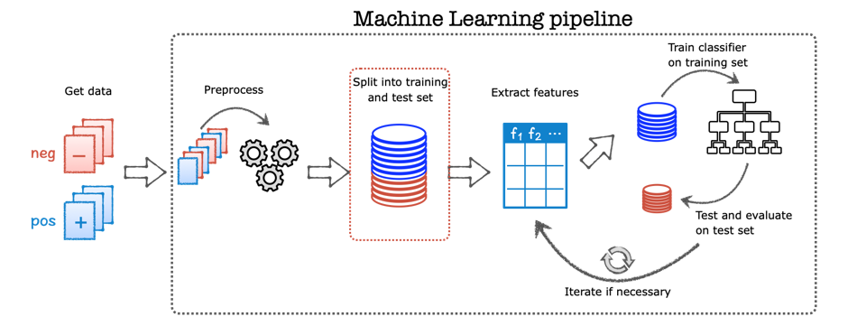

In [14]:
def split(texts, labels, proportion):
    train_data = []
    train_targets = []
    test_data = []
    test_targets = []
    for i in range(0, len(texts)):
        if i < proportion*len(texts):
            train_data.append(texts[i])
            train_targets.append(labels[i])
        else:
            test_data.append(texts[i])
            test_targets.append(labels[i])
    return train_data, train_targets, test_data, test_targets #A

train_data, train_targets, test_data, test_targets = split(texts, labels, 0.8) #B


print(len(train_data))
print(len(train_targets))
print(len(test_data))
print(len(test_targets))
print(train_targets[:10])
print(test_targets[:10]) #C

#A Function split splits input lists of texts and labels into training and test sets using predefined proportion
#B Use the proportion 0.8 to allocate 80% of the data to the training set and 20% to the test set
#C Print out the length of each list as well as the labels for the first 10 items in the target lists

1600
1600
400
400
[1, -1, 1, 1, -1, -1, -1, -1, 1, -1]
[-1, 1, 1, -1, -1, 1, -1, 1, 1, 1]


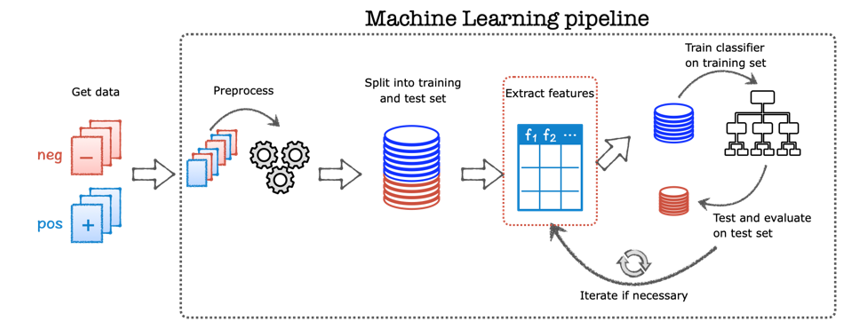

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
train_counts = count_vect.fit_transform(train_data) #A
print(train_counts.shape) #B

#A The fit_transform method extracts the shared vocabulary from the training set and estimates word frequency
#B Let’s print out the size of the train_counts data structure

(1600, 36094)


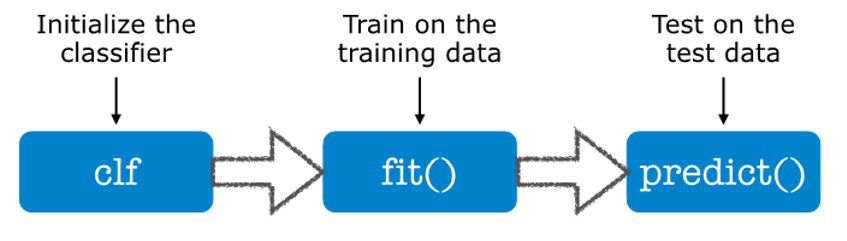

In [16]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(train_counts, train_targets) #A
test_counts = count_vect.transform(test_data) #B
predicted = clf.predict(test_counts) #C

for text, label in list(zip(test_data, predicted))[:10]:
  if label==1:
    print('%r => %s' % (text[:100], "pos"))
  else:
    print('%r => %s' % (text[:100], "neg")) #D

#A Initialize the classifier and train the model on the training data using fit method
#B Extract features from the test data by applying the transform method of the CountVectorizer
#C Apply the classifier to make predictions on the test set
#D Print out some results, for example the predicted labels for the first 10 reviews from the test set

'lengthy and lousy are two words to describe the boring drama the english patient great acting music ' => pos
'capsule a short punchy action sequel to the two dinosaur films made by steven spielberg joe johnston' => neg
'now lets first look into the history of shark films there was the unforgettable jaws the exciting ja' => neg
'five girls spend a day in a closed building doing inventory when a strange box gets delivered there ' => neg
'one sided doom and gloom documentary about the possible annihilation of the human race as foretold b' => neg
"robert redford 's a river runs through it is not a film i watch often it is a masterpiece -- one of " => pos
"susan granger 's review of america 's sweethearts columbia sony what a waste of a talented cast bill" => neg
'  the fugitive is probably one of the greatest thrillers ever made it takes realistic believable cha' => pos
'just look back two years ago at the coen brothers comedic gem the big lebowski change the actors tak' => pos
'plot duri

In [17]:
from sklearn.pipeline import Pipeline #A
from sklearn.preprocessing import Binarizer #B

text_clf = Pipeline([('vect', CountVectorizer(min_df=10, max_df=0.5)),
                     ('binarizer', Binarizer()),
                     ('clf', MultinomialNB()),
                    ]) #C
text_clf.fit(train_data, train_targets)
print(text_clf) #D
predicted = text_clf.predict(test_data) #E

#A Import Pipeline functionality
#B Import the Binarizer tool to record absence or presence of features
#C Add any tools of your choice to the pipeline
#D You can print out the full list of tools included in the pipeline with the activated options
#E Apply the usual fit-predict routine

Pipeline(steps=[('vect', CountVectorizer(max_df=0.5, min_df=10)),
                ('binarizer', Binarizer()), ('clf', MultinomialNB())])


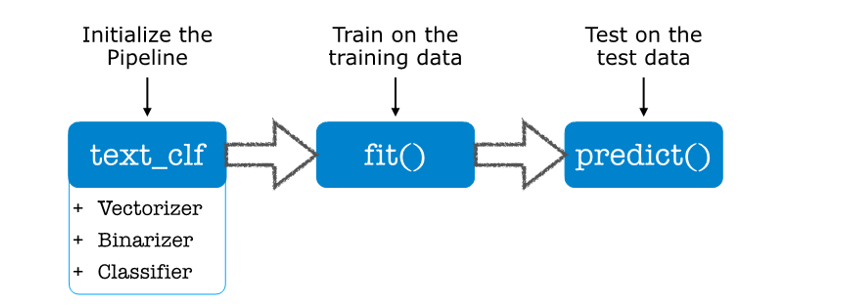

In [18]:
from sklearn import metrics #A

print("\nConfusion matrix:")
print(metrics.confusion_matrix(test_targets, predicted))
print(metrics.classification_report(test_targets, predicted)) #B

#A Import the collection of metrics
#B Print out the confusion matrix and the whole classification_report


Confusion matrix:
[[173  29]
 [ 41 157]]
              precision    recall  f1-score   support

          -1       0.81      0.86      0.83       202
           1       0.84      0.79      0.82       198

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



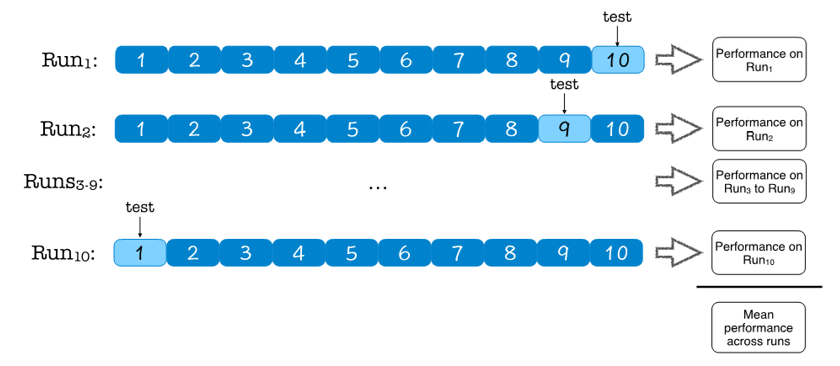

In [19]:
from sklearn.model_selection import cross_val_score, cross_val_predict #A

scores = cross_val_score(text_clf, texts, labels, cv=10) #B
print(scores)
print("Accuracy: " + str(sum(scores)/10)) #C
predicted = cross_val_predict(text_clf, texts, labels, cv=10) #D
print("\nConfusion matrix:")
print(metrics.confusion_matrix(labels, predicted))
print(metrics.classification_report(labels, predicted)) #E

#A Import cross_val_score and cross_val_predict functionality
#B Specify the number of folds with the cv option and return the accuracy scores on each run
#C Calculate the average accuracy across k folds
#D Return predicted values from each fold
#E Print out the evaluation report as you did before

[0.87  0.805 0.87  0.785 0.86  0.82  0.845 0.85  0.81  0.845]
Accuracy: 0.8360000000000001

Confusion matrix:
[[862 138]
 [190 810]]
              precision    recall  f1-score   support

          -1       0.82      0.86      0.84      1000
           1       0.85      0.81      0.83      1000

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



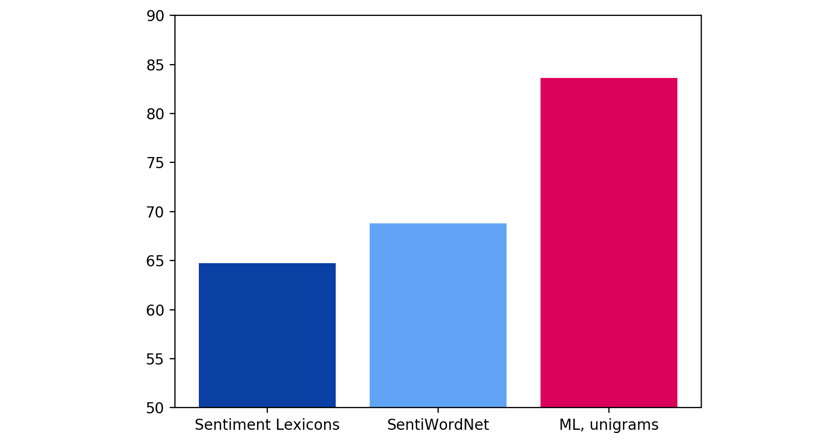

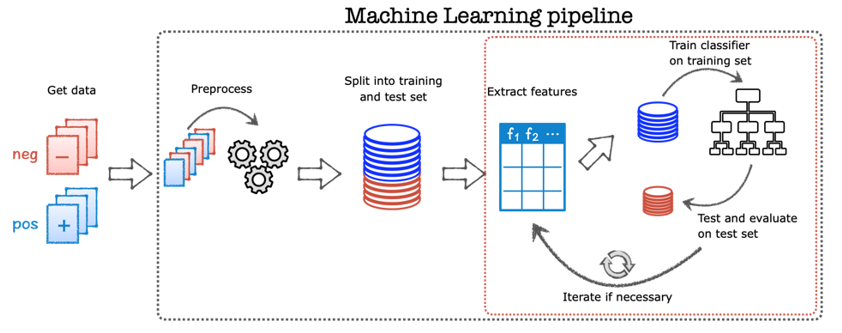

In [20]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), #A
                      ('binarizer', Binarizer()),
                      ('clf', MultinomialNB())
                    ])

scores = cross_val_score(text_clf, texts, labels, cv=10)
print(scores)
print("Accuracy: " + str(sum(scores)/10))
predicted = cross_val_predict(text_clf, texts, labels, cv=10)
print("\nConfusion matrix:")
print(metrics.confusion_matrix(labels, predicted))
print(metrics.classification_report(labels, predicted)) #B

#A The only option you need to update is the ngram_range of the CountVectorizer
#B The rest of the code is the same as before

[0.865 0.845 0.875 0.795 0.89  0.82  0.865 0.88  0.795 0.875]
Accuracy: 0.8504999999999999

Confusion matrix:
[[819 181]
 [118 882]]
              precision    recall  f1-score   support

          -1       0.87      0.82      0.85      1000
           1       0.83      0.88      0.86      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [21]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(2, 2))),
                      ('binarizer', Binarizer()),
                      ('clf', MultinomialNB())
                    ])

scores = cross_val_score(text_clf, texts, labels, cv=10)
print(scores)
print("Accuracy: " + str(sum(scores)/10))
predicted = cross_val_predict(text_clf, texts, labels, cv=10)
print("\nConfusion matrix:")
print(metrics.confusion_matrix(labels, predicted))
print(metrics.classification_report(labels, predicted))

[0.88  0.82  0.885 0.795 0.885 0.82  0.865 0.86  0.82  0.865]
Accuracy: 0.8495000000000001

Confusion matrix:
[[802 198]
 [103 897]]
              precision    recall  f1-score   support

          -1       0.89      0.80      0.84      1000
           1       0.82      0.90      0.86      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [22]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 3))),
                      ('binarizer', Binarizer()),
                      ('clf', MultinomialNB())
                    ])

scores = cross_val_score(text_clf, texts, labels, cv=10)
print(scores)
print("Accuracy: " + str(sum(scores)/10))
predicted = cross_val_predict(text_clf, texts, labels, cv=10)
print("\nConfusion matrix:")
print(metrics.confusion_matrix(labels, predicted))
print(metrics.classification_report(labels, predicted))

[0.89  0.86  0.87  0.835 0.895 0.82  0.86  0.855 0.825 0.88 ]
Accuracy: 0.859

Confusion matrix:
[[810 190]
 [ 92 908]]
              precision    recall  f1-score   support

          -1       0.90      0.81      0.85      1000
           1       0.83      0.91      0.87      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



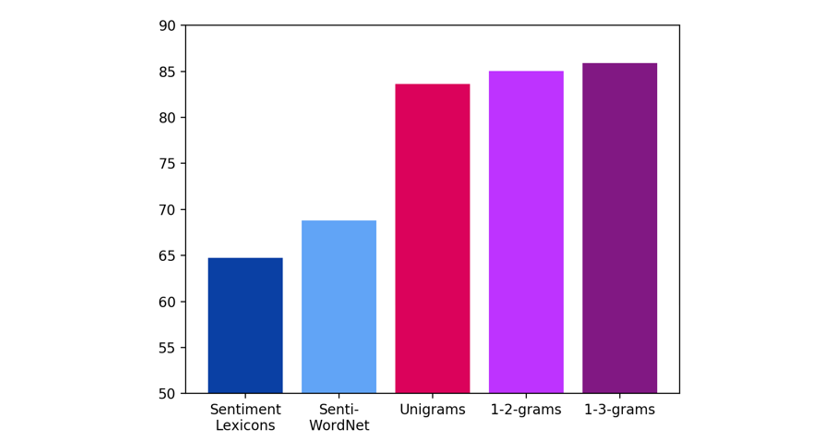

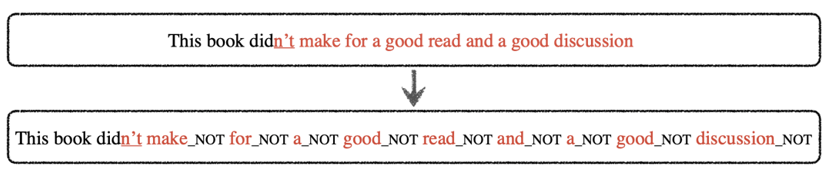

In [23]:
from nltk.sentiment.util import mark_negation #A

def text_filter_neg(a_dict, label, exclude_lists):
    data = []
    for rev_id in a_dict.keys():
        tokens = []
        for sent in a_dict.get(rev_id).sents:
            neg_tokens = mark_negation(sent.text.split())  #B
            for token in neg_tokens:
                if not token in exclude_lists:
                    tokens.append(token)
        data.append((' '.join(tokens), label))
    return data

def prepare_data_neg(pos_docs, neg_docs, exclude_lists): #C
    data = text_filter_neg(pos_docs, 1, exclude_lists)
    data += text_filter_neg(neg_docs, -1, exclude_lists)
    random.seed(42)
    random.shuffle(data)
    texts = []
    labels = []
    for item in data:
        texts.append(item[0])
        labels.append(item[1])
    return texts, labels

texts_neg, labels_neg = prepare_data_neg(pos_docs, neg_docs, punctuation_list) #D
print(len(texts_neg), len(labels_neg))
print(texts_neg[0]) #E

#A Add NLTK’s negation handling functionality via mark_negation
#B Implement a text_filter_neg function that applies mark_negation to the review content
#C Prepare the data for machine learning classification as you did before
#D As before (in Code Listing 8.6), store the processed texts and labels in two data structures
#E Print out the length of each of these data structures and the processed content of the first review

2000 2000
the central focus of michael winterbottom's welcome to sarajevo is sarajevo itself the city under siege and its different effect on the characters unfortunate enough to be stuck there it proves the backdrop for a stunningly realized story which refreshingly strays from mythic portents platoon racial tumultuosness the risible the walking dead or a tinge of schmaltziness schindler's list the two leads stephen dillane as a reporter and emira nusevic as an orphan with a plight few can identify with are extremely believable not one_NEG moment_NEG with_NEG them_NEG involved_NEG rings_NEG false_NEG the question is not what_NEG went_NEG right_NEG the question is what went wrong for one the film fails to provide a political overview of the war as it progresses the dillane characters reports an american plane departing from sarajevo as it departs and that's about it the assortment of high-profile supporting actors ranging from woody harrelson as a yankee reporter into liquor and cigarr

In [24]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                     ('binarizer', Binarizer()),
                     ('clf', MultinomialNB())
                    ])

scores = cross_val_score(text_clf, texts, labels, cv=10)
print(scores)
print("Accuracy: " + str(sum(scores)/10))
predicted = cross_val_predict(text_clf, texts, labels, cv=10)
print("\nConfusion matrix:")
print(metrics.confusion_matrix(labels, predicted))
print(metrics.classification_report(labels, predicted))

[0.865 0.845 0.875 0.795 0.89  0.82  0.865 0.88  0.795 0.875]
Accuracy: 0.8504999999999999

Confusion matrix:
[[819 181]
 [118 882]]
              precision    recall  f1-score   support

          -1       0.87      0.82      0.85      1000
           1       0.83      0.88      0.86      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



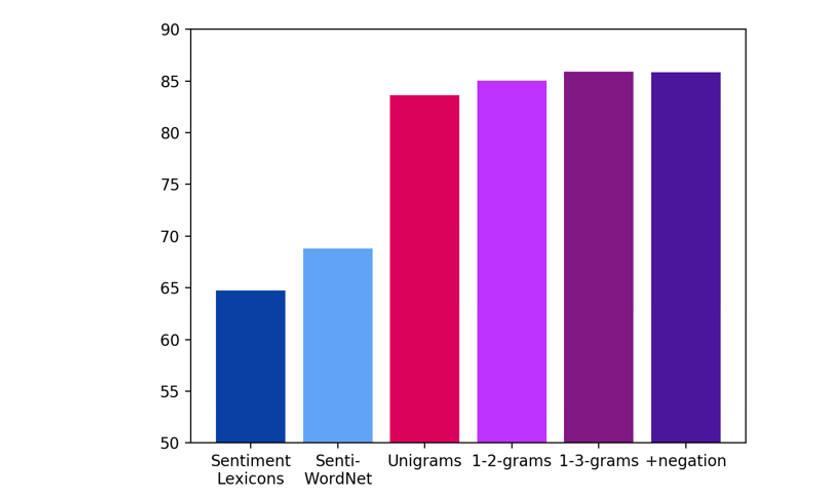

[Large Movie DataSet](https://ai.stanford.edu/%7Eamaas/data/sentiment/)

[Sentence Polarity DataSet](http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz)